# Beiwe

In [1]:
import os, sys, matplotlib, re, io, traceback
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import isnan, nan, inf
from matplotlib.widgets import Slider
from glob import glob
from ipywidgets import *
from datetime import datetime, timedelta
from dateutil.tz import tzlocal
import ipywidgets as widgets
from IPython.display import clear_output, display, HTML
from termcolor import colored
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.options.display.width = 1000
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 100000

In [2]:
# Setup all paths and sources
data_path = os.getenv('HOME')+'/projects/beiwe-data/GxXEPM08ZK0GS1gIaLe9YhEn/'
user_list = os.listdir(data_path)
feature_list = ['accel', 'callLog', 'tapsLog', 'usage', 'accessibilityLog', 'gps', 'light', 'powerState', 'textsLog']
user_map = {'Nikolas old ZTE':'16kbga47', 'Nikolas':'1s3g19f7', 'IMH1-Judy':'33kr56tx',
            'IMH2-Amirah':'1tfan3jn', 'Nikolas old Nokia':'8e3ukdwy', 'Praveen':'d35pt9m4',
            'Faye':'drdlfo5c', 'Robert':'gqmrnhvv', 'Xuancong':'hcy9th57'}

df_all, cols_all = {}, {}

In [3]:
# utility functions
def convert_timestamp(timestamp, zone=tzlocal()):
    data = pd.to_datetime(str(timestamp), unit='ms', origin='unix')
    return data.tz_localize('UTC').tz_convert(zone) if zone != 'UTC' else data

def load_csv(fn, **kwargs):
    Ls = open(fn).read().splitlines()
    last_good_line = 0
    for i,L in enumerate(Ls):
        if i>0 and not L[0:13].isdigit() and not (len(L)>88 and ',' not in L[0:88]):
            Ls[last_good_line] = ''.join(Ls[last_good_line:i+1])
            Ls[i] = ''
        else:
            last_good_line = i
    txt = re.sub(r'(\[[^]]*),([^]]*\])', '\\1\\2', '\n'.join([L for L in Ls if L]))
    txt = re.sub(r'(\[[^]]*),([^]]*\])', '\\1\\2', txt)
    txt = re.sub(r'(\[[^]]*),([^]]*\])', '\\1\\2', txt)
    try:
        ret = pd.read_csv(io.StringIO(txt), **kwargs)
    except:
        traceback.print_exc()
        print('CSV error: in File %s ...'%fn[len(data_path):])
    return ret

def create_df(user, feature):
    dir_path = os.path.join(data_path, user, feature)
    df = pd.concat([load_csv(fn, error_bad_lines=True) for fn in sorted(glob(dir_path+'/*.csv'))])
#     print(df.columns)
    if 'timestamp' in df.columns:
        df['datetime'] = df.timestamp.apply(convert_timestamp)
    df = df.reset_index(drop=True)
    return df

def load_col(user, feature):
    dir_path = os.path.join(data_path, user, feature)
    df = load_csv(glob(dir_path+'/*.csv')[0], error_bad_lines=False)
    return df.columns

def draw_arrows(axes, df, TH=0.01):
    data = df[['timestamp', 'longitude', 'latitude']]
    _, x_span, y_span = data.max()-data.min()
    th = np.sqrt(x_span**2+y_span**2)*TH
    HW = np.sqrt(x_span**2+y_span**2)*.005
    HL = np.sqrt(x_span**2+y_span**2)*.01
    lx = ly = None
    for r in data.itertuples():
        x, y = r.longitude, r.latitude
        if lx != None:
            delta = np.sqrt((x-lx)**2+(y-ly)**2)
            if delta > th:
                axes.arrow((x+lx)*0.5, (y+ly)*0.5, (x-lx)*HW/delta, (y-ly)*HW/delta,
                           width=0, head_width=HW, head_length=HL)
        lx, ly = x,y
        
def date2datetime(d):
    return datetime(d.year, d.month, d.day, tzinfo=tzlocal())

def generate_colormap(N):
    arr = np.arange(N)/N
    N_up = int(np.ceil(N/7)*7)
    arr.resize(N_up)
    arr = arr.reshape(7,N_up//7).T.reshape(-1)
    ret = matplotlib.cm.hsv(arr)
    n = ret[:,3].size
    a = n//2
    b = n-a
    for i in range(3):
        ret[0:n//2,i] *= np.arange(0.2,1,0.8/a)
    ret[n//2:,3] *= np.arange(1,0.2,-0.8/b)
    return ret

In [4]:
%matplotlib notebook

topNmax = 100
F1 = {'number of readings':'.count()', 'max value':'.max()', 'min value':'.min()', 'mean value':'.mean()', 'grouped values':''}
daysofweek = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
drop0 = Dropdown(options=['value'], description='Select Column')
drop1 = Dropdown(options=['mean', 'max', 'min', 'median', 'std'], description='Agg. Func', layout={'visibility':'hidden'})
drop1_M = {'value heatmap':['Agg. Func', ['mean', 'max', 'min', 'median', 'std']],
           'time chart stacked count':['top N', list(range(1,topNmax+1))+[inf]],
           'frequency distribution (h-bar)':['top N', list(range(1,topNmax+1))+[inf]],
           'frequency distribution (pie)':['top N', list(range(1,topNmax+1))+[inf]],
           'histogram of values':['# of bins', list(range(2,201))]}
# slider0 = FloatSlider(min=-1, max=1, step=.001, value=0, layout=Layout(width='95%'), continuous_update=False, description='Date Offset')
dateoffset0 = widgets.BoundedFloatText(value=0, min=-10, max=10.0, step=1, description='Date Offset')
interval0 = Dropdown(options=['15min', '30min', '1H', '2H', '3H', '6H', '12H', '1D', '2D', '1W', '1M'], value='1D', description='Bin Interval')
fig, axes = None, None
def update(Username, StartDate, LastDate, DateOffset, Feature, Function, Interval, ContOffset, PlotType, SelCol, Extra, TakeLog,
           DrawArrow, SpreadXYaxis, SortByTimestamp, DoPlot):
    global fig, axes, cols_all
    
    ## Prepare control items
    dateoffset0.step = 0.01 if ContOffset else 1
    interval0.layout.visibility = 'hidden' if Function.startswith('pass through') else 'visible'
    
    # Set select columns => drop0
    if Feature not in cols_all:
        cols_all[Feature] = [c for c in load_col(user_map[Username], Feature) if c not in ['timestamp', 'datetime']]
    drop0.options = cols = cols_all[Feature]
    drop0.value = SelCol = SelCol if SelCol in cols else ('value' if 'value' in cols else cols[0])
    drop0.layout.visibility = 'hidden' if PlotType=='XY path' or PlotType.startswith('display') else 'visible'
    
    # Set Extra
    if PlotType in drop1_M:
        drop1.description,drop1.options = drop1_M[PlotType]
        drop1.layout.visibility = 'visible'
    else:
        drop1.layout.visibility = 'hidden'
    
    # Switch matplot backend
    if PlotType == 'XY path' and matplotlib.get_backend()!='nbAgg':
        plt.switch_backend('nbAgg')
    elif PlotType != 'XY path' and matplotlib.get_backend()=='nbAgg':
        plt.switch_backend('module://ipykernel.pylab.backend_inline')
    if not DoPlot: return display()
    
    
    ## Execute draw function
    key = Username + ' : ' + Feature
    if key not in df_all:
        print('Loading data from files ... [Username=%s, Feature=%s]'%(Username, Feature), flush=True)
        df_all[key] = create_df(user_map[Username], Feature)
    else:
        print('Loading data from cache ... [Username=%s, Feature=%s]'%(Username, Feature), flush=True)
    dfa = df_all[key]
    
    print('Processing data ...', flush=True)
    dfc = dfa.sort_values('timestamp') if SortByTimestamp else dfa.copy()
    df = dfc = dfc.ffill()
    earliest_date, latest_date = df.iloc[0]['datetime'].to_pydatetime(), df.iloc[-1]['datetime'].to_pydatetime()
    start_date = earliest_date if StartDate==None else date2datetime(StartDate)
    end_date = latest_date if LastDate==None else date2datetime(LastDate)+timedelta(days=1)
    if StartDate!=None or LastDate!=None:
        if StartDate!=None:
            dateoffset0.min = -((date2datetime(StartDate) - earliest_date).days + 1)
        if LastDate!=None:
            dateoffset0.max = (latest_date - date2datetime(LastDate)).days
        if DateOffset!=0:
            dateoffset = timedelta(days=1)*DateOffset
            start_date += dateoffset
            end_date += dateoffset
        df = df[(df.datetime>=start_date) & (df.datetime<end_date)]
    else:
        dateoffset0.max = dateoffset0.min = dateoffset0.value = 0
    print(colored('Actual Start Date: %s ; End Date: %s'%(start_date, end_date), 'red', attrs=['bold']))
    
    if TakeLog:
        df[[SelCol]] = np.log(df[[SelCol]]+1)
        
    scale = 0.9 if matplotlib.get_backend()=='nbAgg' else 1.0
    figsize = [16*scale, 9*scale]
    
    # Transform values
    if Function in F1:
        data = df[['datetime',SelCol]].groupby(pd.Grouper(freq=Interval, key='datetime'))
        data = eval('data'+F1[Function])
    elif Function == 'value range':
        data1 = df[['datetime', SelCol]].groupby(pd.Grouper(freq=Interval, key='datetime'))
        data = data1.min().rename(columns={SelCol:'min'})
        data['max'] = data1.max()[SelCol]-data['min']
    elif Function == 'pass through selected':
        data = df[[SelCol]]
    elif Function == 'pass through all':
        data = df
        
    # Start plotting
    if PlotType == 'time chart':
        figsize = (len(data)*0.4*scale, 3*scale)
        xy_plot = data.plot.bar(stacked=True, figsize=figsize, rot=45) if type(data) is tuple and len(data)==2 else data.plot.bar(figsize=figsize, rot=45)
        xy_plot.set_xticklabels(xy_plot.get_xticklabels(), ha='right')
    elif PlotType == 'time chart stacked count':
        data0 = data.filter(lambda t:True) if 'DataFrameGroupBy' in str(type(data)) else data
        stats = data0[SelCol].value_counts()
        N_cls_present = stats.size
        N_cls = min(Extra, N_cls_present)
        selected_cls = stats.index.tolist()[:N_cls]
        if N_cls_present > N_cls:
            data0[SelCol] = data0[SelCol].apply(lambda t:t if t in selected_cls else '<Others>')
            selected_cls += ['<Others>']
            N_cls += 1
        data = data0.groupby(pd.Grouper(freq=Interval, key='datetime'))
        map_null = lambda t:t if len(t) else {selected_cls[0]:0}
        data = pd.DataFrame.from_dict({g[0]:map_null(g[1][SelCol].value_counts()) for g in data}, orient='index').fillna(0)
        xy_plot = data[selected_cls[::-1]].plot.bar(stacked=True, rot=45, figsize=figsize, color=generate_colormap(N_cls))
        xy_plot.set_xticklabels(xy_plot.get_xticklabels(), ha='right')
        xy_plot.get_figure().subplots_adjust(right=0.8)
        xy_plot.legend(loc='center left', prop={'size': 10}, bbox_to_anchor=(1,0,0.2,1))
    elif PlotType == 'value heatmap':
        fig, ax = plt.subplots(figsize=[v*0.8 for v in figsize])
        data = data.reset_index()
        data['day_of_week'] = data.datetime.dt.dayofweek
        data['hour'] = data.datetime.dt.hour
        piv = pd.pivot_table(data, values=SelCol, index='hour', columns='day_of_week', fill_value=0, aggfunc=eval('np.'+Extra))
        ax = sns.heatmap(piv, annot=True, cmap="plasma", fmt='.5g', linewidths=1, xticklabels=daysofweek)
        ax.invert_yaxis()
        plt.tight_layout()
        plt.title(SelCol)
    elif PlotType == 'XY path':
        dfs = df if SpreadXYaxis else dfc
        x_max, x_min = float(dfs[['longitude']].max()), float(dfs[['longitude']].min())
        y_max, y_min = float(dfs[['latitude']].max()), float(dfs[['latitude']].min())
        D = max((x_max-x_min), (y_max-y_min))*0.05
        xy_plot = df.plot.line(x='longitude', y='latitude', xlim=[x_min-D, x_max+D], ylim=[y_min-D, y_max+D], figsize=figsize)
        xy_plot.set_aspect(1)
        if DrawArrow:
            draw_arrows(xy_plot, df)
    elif PlotType == 'histogram of values':
        xy_plot = data.plot.hist(figsize=figsize, bins=Extra)
    elif PlotType.startswith('frequency distribution'):
        data = data[SelCol].value_counts()
        N_classes = min(Extra, len(data))
        sel_classes = data[:N_classes]
        if len(data)>N_classes:
            sel_classes['<Others>'] = data[N_classes:].sum()
        data = sel_classes[::-1]
        N_cls_total = len(data)
        print('Total number of categories (including [other]) = %d'%N_cls_total)
        if 'pie' in PlotType:
            fig_sz = np.clip(N_cls_total,8,24)
            xy_plot = data.plot.pie(figsize=[fig_sz,fig_sz], title='[%s]'%SelCol, colors=generate_colormap(N_cls_total))
        else:
            figsize[1] = max(4, len(data)*9/40)
            xy_plot = data.plot.barh(figsize=figsize, title='[%s]'%SelCol)
    elif PlotType == 'display pipeline processed data':
        display(data)
    elif PlotType == 'display selected/pre-computed data':
        display(df)
    elif PlotType == 'display raw unprocessed data':
        display(dfa)
    else:
        data.plot()
    print('Loading finished! Plotting ...', flush=True)

W = interactive(update,
    Username = Dropdown(options=sorted(user_map.keys()), value='Xuancong'),
    StartDate = DatePicker(value=None),
    LastDate = DatePicker(value=None),
    DateOffset = dateoffset0,  # 3
    Feature = Dropdown(options=feature_list, value='light'),
    Function = ['number of readings', 'max value', 'min value', 'mean value', 'value range', 'grouped values', 'pass through selected', 'pass through all'],
    Interval = interval0, ContOffset = Checkbox(value=False, description="Continuous Date Offset"), # 7
    PlotType = ['time chart', 'time chart stacked count', 'value heatmap', 'XY path', 'frequency distribution (h-bar)', 'frequency distribution (pie)',
                'histogram of values', 'display pipeline processed data', 'display selected/pre-computed data', 'display raw unprocessed data'],
    Extra = drop1, SelCol = drop0, # 9
    TakeLog = False, DrawArrow = False, SpreadXYaxis = False, SortByTimestamp = Checkbox(description='Sort by row timestamp'),
    DoPlot = ToggleButton(value=False, description='Update Plot'), # -2
    )
VBox([HBox(W.children[0:4]), HBox(W.children[4:8]), HBox(W.children[8:11]), HBox(W.children[11:-1]), W.children[-1]])

## Padding (Jupyter notebook UI has a bug that if the following is removed, the UI will scroll upon every interactive click)

<IPython.core.display.Javascript object>


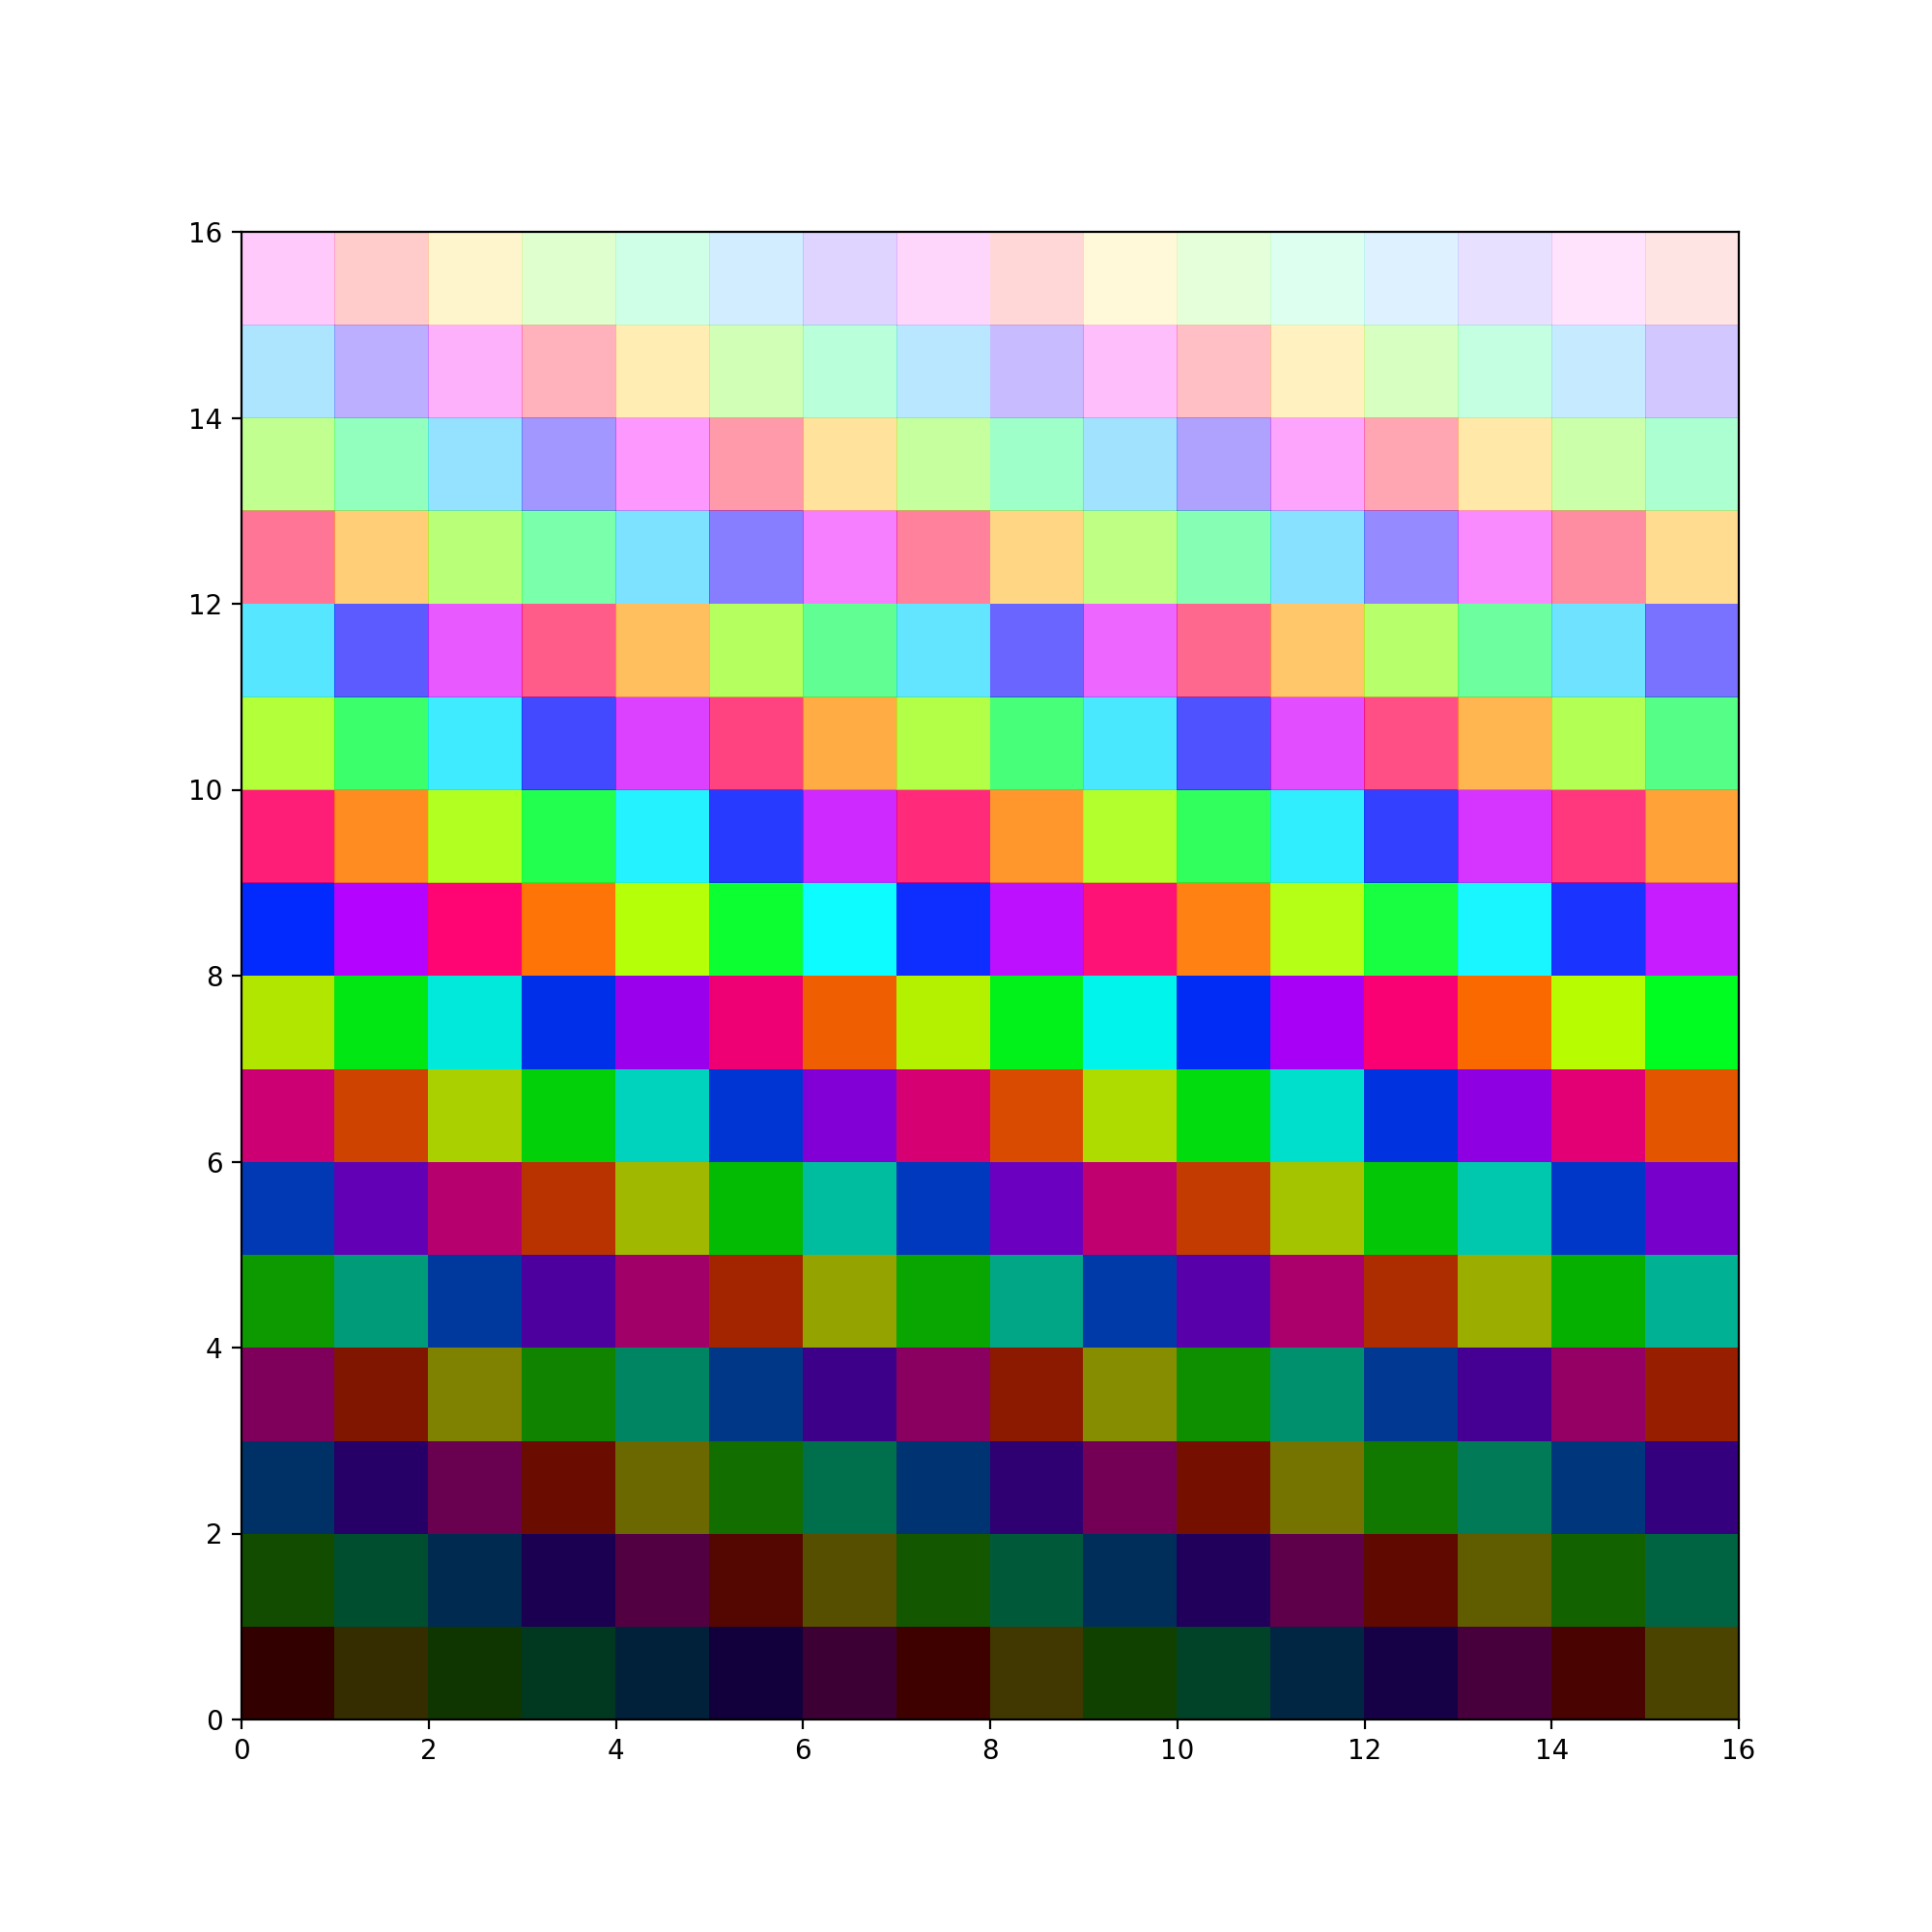

In [5]:
from matplotlib.colors import ListedColormap

plt.switch_backend('nbAgg')
def generate_colormap(N):
    S = 7
    arr = np.arange(N)/N
    N_up = int(np.ceil(N/S)*S)
    arr.resize(N_up)
    arr = arr.reshape(S,N_up//S).T.reshape(-1)
    ret = matplotlib.cm.hsv(arr)
    n = ret[:,3].size
    a = n//2
    b = n-a
    for i in range(3):
        ret[0:n//2,i] *= np.arange(0.2,1,0.8/a)
    ret[n//2:,3] *= np.arange(1,0.1,-0.9/b)
#     print(ret)
    return ret

N = 16
H = np.arange(N*N).reshape([N,N])
fig = plt.figure(figsize=(10, 10))
ax = plt.pcolor(H, cmap=ListedColormap(generate_colormap(N*N)))